# Use ModelFit to tune th empirical gaussian model to the data generated by other models

In [1]:
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from floris import TimeSeries
from floris.layout_visualization import plot_turbine_labels, plot_turbine_points

from flasc.model_fit.cost_library import turbine_power_error_abs
from flasc.model_fit.model_fit import ModelFit
from flasc.model_fit.opt_library import opt_optuna

# Open and inspect data to tune to

In [2]:
# Load the data from previous example
with open("farm_data.pkl", "rb") as f:
    data = pickle.load(f)

# Unpack
df_jensen = data["df_jensen"]
df_gch = data["df_gch"]
df_emg = data["df_emg"]
df_turbo = data["df_turbo"]
fmodel_emg = data["fmodel_emg"]
fmodel_emg_unc = data["fmodel_emg_unc"]

<Axes: >

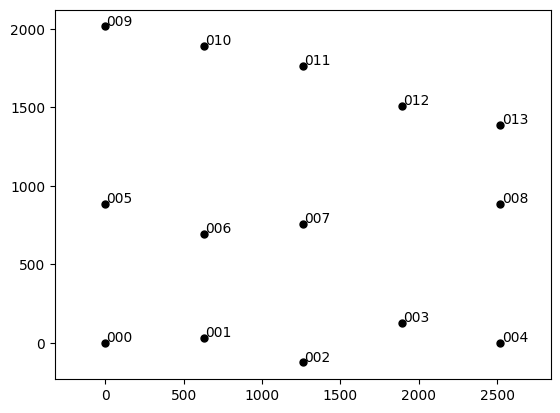

In [3]:
# Show the farm layout for reference

fig, ax = plt.subplots()
plot_turbine_points(fmodel_emg, ax)
plot_turbine_labels(fmodel_emg, ax)

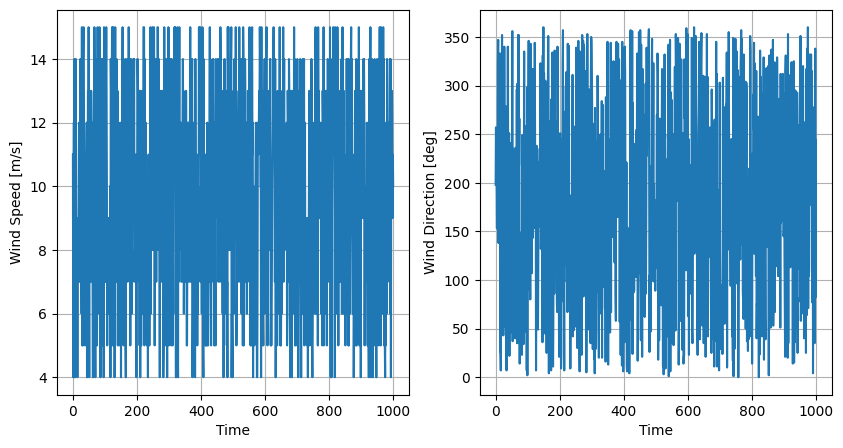

In [4]:
# Plot the time series of wind speed and direction
fig, axarr = plt.subplots(1,2, figsize=(10, 5))
axarr[0].plot(df_emg["ws"], label="Wind Speed")
axarr[0].set_xlabel("Time")
axarr[0].set_ylabel("Wind Speed [m/s]")
axarr[0].grid()

axarr[1].plot(df_emg["wd"], label="Wind Direction")
axarr[1].set_xlabel("Time")
axarr[1].set_ylabel("Wind Direction [deg]")
axarr[1].grid()
plt.show()

<PolarAxes: >

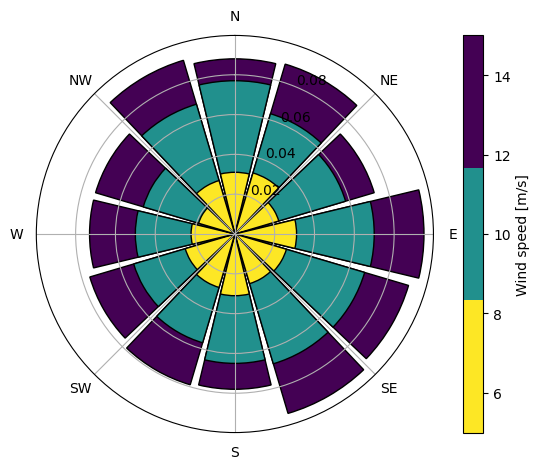

In [5]:
# Plot the wind rose
time_series = TimeSeries(
    wind_directions=df_emg["wd"].values,
    wind_speeds=df_emg["ws"].values,
    turbulence_intensities=0.06
)
time_series.to_WindRose().plot(ws_step=5.0, wd_step=30.0)

# Set up ModelFit parameters

In [6]:
# Set up lists of names and data sets
data_sets = [df_jensen, df_gch, df_turbo]
data_set_names = ['jensen', 'gch', 'turbopark']

In [7]:
# Define the parameters to tune within ModelFit
# In this example we tune the first and second wake expansion rates of the empirical 
# gaussian wake model

# The parameter list locates the tuning parameter within the floris model
parameter_list = [
    ("wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"),
    ("wake", "wake_velocity_parameters", "empirical_gauss", "wake_expansion_rates"),
]

# Given a short name to each parameter
parameter_name_list = ["we_1", "we_2"]

# Range of values
parameter_range_list = [(0.00, 0.05), (0.00, 0.05)]

# wake_expansion_rates is an array so in this case need to specify the index
# of the parameter to tune
parameter_index_list = [0, 1]

In [8]:
# Get the starting (default) values of the parameters
default_values = []
for p,name,i in zip(parameter_list,parameter_name_list, parameter_index_list):
    v = fmodel_emg.get_param(p,i)
    default_values.append(v)
    print(f"{name}: {v}")

we_1: 0.023
we_2: 0.008


# Perform the optimizations

All the data sets were generated using the UncertainFlorisModel with wd_std = 3 degrees.  For demonstration purposes, optimize the empirical gaussian model's parameters using a model with and without uncertainty to show the impact on the results.

In [9]:
# Initialize the result arrays
result_model = []
opt_setting = []
result_param_name = []
result_value = []

In [10]:
# Save the baseline values
for df_name in data_set_names:
    for param_name, param_value in zip(parameter_name_list, default_values):
        result_model.append(df_name)
        opt_setting.append("baseline")
        result_param_name.append(param_name)
        result_value.append(param_value)

#### Tune empirical guassian wake model with no uncertainty

In [11]:
for d_name, df in zip(data_set_names, data_sets):
    print(f"Data set: {d_name}")

    # Define a ModelFit object using this data set
    # Specify absolute turbine power error as the cost function
    mf = ModelFit(
        df = df_jensen,
        fmodel = fmodel_emg,
        cost_function=turbine_power_error_abs,
        parameter_list=parameter_list,
        parameter_name_list=parameter_name_list,
        parameter_range_list=parameter_range_list,
        parameter_index_list=parameter_index_list,
    )

    # Calculate the baseline cost (evaluate cost with default parameters)
    baseline_cost = mf.evaluate_floris()

    # Optimize for 30 trials
    opt_result, study = opt_optuna(mf, timeout=None, n_trials=30)

    # Collect the opt_params
    opt_params = opt_result["parameter_values"]

    # Store the results
    for param_name, param_value in zip(parameter_name_list, opt_params):
        result_model.append(d_name)
        opt_setting.append("Opt with FlorisModel")
        result_param_name.append(param_name)
        result_value.append(param_value)

floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.


Data set: jensen


[I 2025-03-20 07:13:45,122] A new study created in memory with name: no-name-62122bab-9f80-4c89-bf72-28206d0fb6e9
[I 2025-03-20 07:13:45,465] Trial 0 finished with value: 720103.0289644827 and parameters: {'we_1': 0.023, 'we_2': 0.008}. Best is trial 0 with value: 720103.0289644827.
[I 2025-03-20 07:13:45,831] Trial 1 finished with value: 1049092.9200364747 and parameters: {'we_1': 0.010275847753328356, 'we_2': 0.028179730904560715}. Best is trial 0 with value: 720103.0289644827.
[I 2025-03-20 07:13:46,189] Trial 2 finished with value: 1013982.2962853903 and parameters: {'we_1': 0.009032987610470144, 'we_2': 0.04730457980088109}. Best is trial 0 with value: 720103.0289644827.
[I 2025-03-20 07:13:46,557] Trial 3 finished with value: 608153.311188142 and parameters: {'we_1': 0.02518363421388893, 'we_2': 0.047506286920007336}. Best is trial 3 with value: 608153.311188142.
[I 2025-03-20 07:13:46,931] Trial 4 finished with value: 759639.9682324638 and parameters: {'we_1': 0.0166486152270911

Data set: gch


[I 2025-03-20 07:13:56,518] A new study created in memory with name: no-name-572abaa9-c8b7-4959-9f6c-a7b3d93e617b
[I 2025-03-20 07:13:56,900] Trial 0 finished with value: 650239.8160861233 and parameters: {'we_1': 0.02097241227666382, 'we_2': 0.03755776380686712}. Best is trial 0 with value: 650239.8160861233.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
[I 2025-03-20 07:13:57,272] Trial 1 finished with value: 1245555.9287644965 and parameters: {'we_1': 0.0047978744307165646, 'we_2': 0.04298477357743079}. Best is trial 0 with value: 650239.8160861233.
[I 2025-03-20 07:13:57,672] Trial 2 finished with value: 650186.1140334507 and parameters: {'we_1': 0.020650338378771477, 'we_2': 0.04475698608959743}. Best is trial 2 with value: 650186.1140334507.
[I 2025-03-20 07:13:58,083] Trial 3 finished with value: 652961.8805779541 and parameters: {'we_1': 0.02782985047420964, 'we_2': 0.005872610303325182}. Best is trial 2 with value: 650186.1140334507.
[I 202

Data set: turbopark


[I 2025-03-20 07:14:08,219] A new study created in memory with name: no-name-583876dc-ea6b-469a-bbde-b04962a6d205
[I 2025-03-20 07:14:08,588] Trial 0 finished with value: 611220.0845060465 and parameters: {'we_1': 0.025013880967297217, 'we_2': 0.049934602944491896}. Best is trial 0 with value: 611220.0845060465.
[I 2025-03-20 07:14:08,993] Trial 1 finished with value: 778494.1468558058 and parameters: {'we_1': 0.015231676161026421, 'we_2': 0.045670813193800376}. Best is trial 0 with value: 611220.0845060465.
[I 2025-03-20 07:14:09,360] Trial 2 finished with value: 663898.5550569072 and parameters: {'we_1': 0.03260127720679617, 'we_2': 0.04643633756940924}. Best is trial 0 with value: 611220.0845060465.
[I 2025-03-20 07:14:09,746] Trial 3 finished with value: 928423.7158918587 and parameters: {'we_1': 0.04924413809508449, 'we_2': 0.014868074777757857}. Best is trial 0 with value: 611220.0845060465.
[I 2025-03-20 07:14:10,169] Trial 4 finished with value: 686385.2637247551 and parameters

#### Repeat now tuning the UncertainFlorisModel with wd_std = 3 degrees

In [12]:
for d_name, df in zip(data_set_names, data_sets):
    print(f"Data set: {d_name}")

    # Define a ModelFit object using this data set
    # Specify absolute turbine power error as the cost function
    mf = ModelFit(
        df = df_jensen,
        fmodel = fmodel_emg_unc,
        cost_function=turbine_power_error_abs,
        parameter_list=parameter_list,
        parameter_name_list=parameter_name_list,
        parameter_range_list=parameter_range_list,
        parameter_index_list=parameter_index_list,
    )

    # Calculate the baseline cost (evaluate cost with default parameters)
    baseline_cost = mf.evaluate_floris()

    # Optimize for 30 trials
    opt_result, study = opt_optuna(mf, timeout=None, n_trials=30)

    # Collect the opt_params
    opt_params = opt_result["parameter_values"]

    # Store the results
    for param_name, param_value in zip(parameter_name_list, opt_params):
        result_model.append(d_name)
        opt_setting.append("Opt with UncertainFlorisModel")
        result_param_name.append(param_name)
        result_value.append(param_value)


floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.


Data set: jensen


[I 2025-03-20 07:14:20,369] A new study created in memory with name: no-name-bdf42b12-6329-4e88-bdf9-ee30292582a5
[I 2025-03-20 07:14:21,638] Trial 0 finished with value: 382973.58249171195 and parameters: {'we_1': 0.023, 'we_2': 0.008}. Best is trial 0 with value: 382973.58249171195.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
[I 2025-03-20 07:14:22,981] Trial 1 finished with value: 976501.5014681221 and parameters: {'we_1': 0.0028066659046866007, 'we_2': 0.006800436695633749}. Best is trial 0 with value: 382973.58249171195.
[I 2025-03-20 07:14:24,329] Trial 2 finished with value: 396668.922812755 and parameters: {'we_1': 0.016822671772517516, 'we_2': 0.04856576279252586}. Best is trial 0 with value: 382973.58249171195.
[I 2025-03-20 07:14:25,720] Trial 3 finished with value: 884467.5890659322 and parameters: {'we_1': 0.04687341046465383, 'we_2': 0.002201647863561107}. Best is trial 0 with value: 382973.58249171195.
[I 2025-03-20 07:14:27,056] Tr

Data set: gch


[I 2025-03-20 07:15:01,737] A new study created in memory with name: no-name-a5848aae-9c60-47a7-a9aa-e173e88c1028
[I 2025-03-20 07:15:03,069] Trial 0 finished with value: 801284.595321871 and parameters: {'we_1': 0.04192497112141093, 'we_2': 0.009681797473562648}. Best is trial 0 with value: 801284.595321871.
[I 2025-03-20 07:15:04,376] Trial 1 finished with value: 435167.32430434594 and parameters: {'we_1': 0.01489947218877834, 'we_2': 0.012367594424728179}. Best is trial 1 with value: 435167.32430434594.
[I 2025-03-20 07:15:05,636] Trial 2 finished with value: 581693.3378316261 and parameters: {'we_1': 0.032337525774395894, 'we_2': 0.014694498223773212}. Best is trial 1 with value: 435167.32430434594.
[I 2025-03-20 07:15:07,027] Trial 3 finished with value: 795784.8803110044 and parameters: {'we_1': 0.04265677119143194, 'we_2': 0.0033817141653441855}. Best is trial 1 with value: 435167.32430434594.
[I 2025-03-20 07:15:08,450] Trial 4 finished with value: 995819.0804884011 and paramet

Data set: turbopark


[I 2025-03-20 07:15:43,124] A new study created in memory with name: no-name-057c0483-64d4-4ea7-ba3b-061a11b4fedb
[I 2025-03-20 07:15:44,473] Trial 0 finished with value: 601934.5182188858 and parameters: {'we_1': 0.030163896950398505, 'we_2': 0.03813891708552494}. Best is trial 0 with value: 601934.5182188858.
[I 2025-03-20 07:15:45,800] Trial 1 finished with value: 517790.16719893325 and parameters: {'we_1': 0.008211334414549526, 'we_2': 0.049930817779071865}. Best is trial 1 with value: 517790.16719893325.
[I 2025-03-20 07:15:47,189] Trial 2 finished with value: 760085.3722565698 and parameters: {'we_1': 0.03969255504855446, 'we_2': 0.012833154920381779}. Best is trial 1 with value: 517790.16719893325.
[I 2025-03-20 07:15:48,487] Trial 3 finished with value: 838997.4940240826 and parameters: {'we_1': 0.04304983449551352, 'we_2': 0.013273596815324135}. Best is trial 1 with value: 517790.16719893325.
[I 2025-03-20 07:15:49,905] Trial 4 finished with value: 432554.06271197106 and param

# Analyze the results

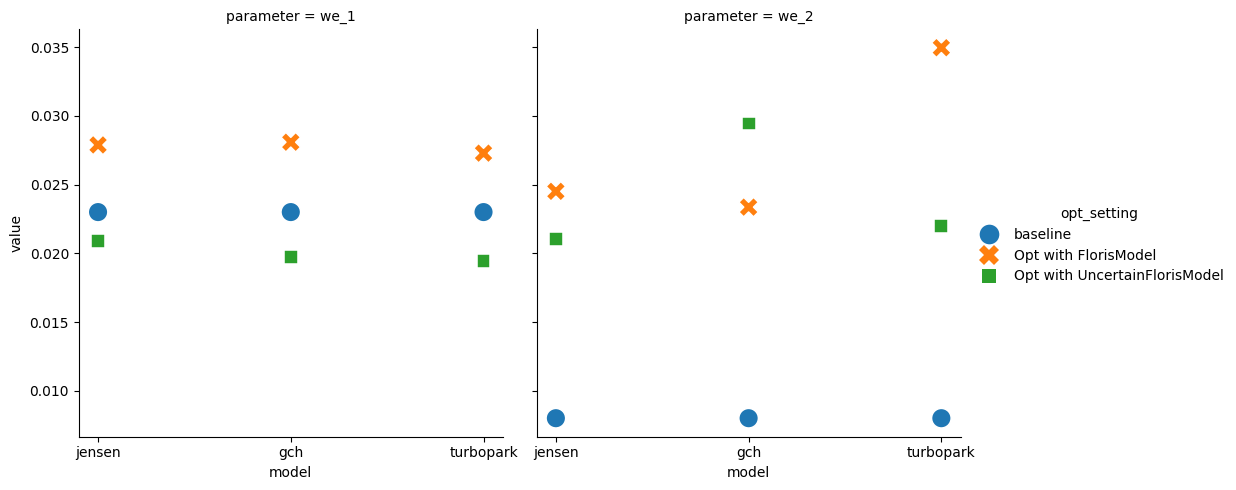

In [13]:
df_result = pd.DataFrame({
    "model": result_model,
    "opt_setting": opt_setting,
    "parameter": result_param_name,
    "value": result_value,
})

sns.relplot(
    data=df_result,
    x='model',
    y='value',
    hue='opt_setting',
    style='opt_setting',
    col='parameter',
    s=200,
)